In [1]:
# import usual libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import f1_score

# our system imports
from aideme import *

%matplotlib inline

In [2]:
def plot_fscore(metrics):
    df_list = [pd.DataFrame.from_dict({i: metric for i, metric in enumerate(ls)}, orient='index') for ls in metrics]
    avg = sum([df['fscore'][~df['fscore'].isna()] for df in df_list]) / len(df_list)
    avg.plot(ylim=[0,1], marker='o')
    plt.show()

In [5]:
# DUMMY DATA
N = int(2e5)
dim = 2
PARTITION = [[0], [1]]#[[0, 1], [2, 3], [4], [5]]
limit = 0.06 #0.63
rng = np.random.RandomState(0)
X = rng.uniform(low=-2, high=2, size=(N, dim))  # do not forget to standardize the data. For this distribution, it should be fine without it.
y_subspace = np.vstack([np.all(np.abs(X[:, p]) < limit, axis=1) for p in PARTITION]).T.astype('float')  # partial labels (for each subspace)
y = y_subspace.min(axis=1)

labeled_set = LabeledSet(y, y_subspace)

# visualize data distribution
print('selectivity :', 100 * y.sum() / len(y), '%')

#plt.figure(figsize=(10,8))
#plt.scatter(X[:, 0], X[:, 1], s=0.05, c=['b' if lb else 'r' for lb in y])
#plt.show()

selectivity : 0.093 %


In [7]:
# SET-UP EXPLORATION CONFIGURATION
REPEAT = 1
NUMBER_OF_ITERATIONS = 100  # number of points to be labeled by the user

SUBSAMPLING = None 

INITIAL_SAMPLER = stratified_sampler(labeled_set, pos=1, neg=1)  # start with one random positive sample and one random negative sample
#INITIAL_SAMPLER = random_sampler(10)

CALLBACK = [ # callback functions to be called at the end of each iteration
    classification_metrics(X, labeled_set.labels, ['fscore']), 
    #three_set_metric,
]
CALLBACK_SKIP = 10


CONVERGENCE_CRITERIA = [
    max_iter_reached(NUMBER_OF_ITERATIONS),
    #all_points_are_known,
    #metric_reached_threshold('fscore', 0.8),
    #metric_reached_threshold('tsm', 0.9),
]

#NOISE_INJECTOR = random_noise_injector(0)  # None, random_noise_injector, gaussian_noise_injector

SEED = list(range(REPEAT))

explore = PoolBasedExploration(INITIAL_SAMPLER, SUBSAMPLING, CALLBACK, CALLBACK_SKIP, CONVERGENCE_CRITERIA)

# ACTIVE LEARNING ALGORITHMS
#learner = RandomSampler(SVC(C=1e5, kernel='rbf', gamma='auto'))  # choose a random point
#learner = SimpleMargin(C=1e7, kernel='rbf')  # choose point closest to SVM decision boundary
#learner = DualSpaceModel(learner, sample_unknown_proba=0.5, mode='positive')  # Dual Space model
learner = KernelQueryByCommittee(n_samples=8, warmup=100, thin=10, rounding=True, rounding_cache=False, z_cut=True, strategy='default', use_cython=False)  # version space algorithm

# FACTORIZED ALGORITHMS
#PARTITION = [[0], [1]]
#learner = FactorizedDualSpaceModel(SimpleMargin(C=1024, kernel='rbf'), partition=PARTITION, mode='positive', sample_unknown_proba=0.5)  # Dual Space model
#learner = SubspatialVersionSpace(n_samples=8, warmup=100, thin=100, rounding=True, rounding_cache=True, z_cut=True, use_cython=True, strategy='opt', partition=PARTITION, label_function='AND', loss='GREEDY')
#learner = SubspatialSimpleMargin(C=1024, kernel='rbf', gamma=5, partition=PARTITION, label_function='AND')


# RUN EXPLORATION
#metrics = explore.run(X, labeled_set, learner, repeat=REPEAT, seeds=SEED)  # 'repeat' specifies how many times to repeat the exploration process
dfs = []
for run in explore.run(X, labeled_set, learner, repeat=REPEAT, seeds=SEED, return_generator=True):
    #for m in run: print(m)
    dfs.append(pd.DataFrame(run))
    

# COMPUTE AVERAGE F-SCORE OVER ALL REPEATS AND PLOT
#plot_fscore(metrics)
#df = pd.DataFrame.from_dict({i: metric for i, metric in enumerate(metrics[0])}, orient='index')
#df

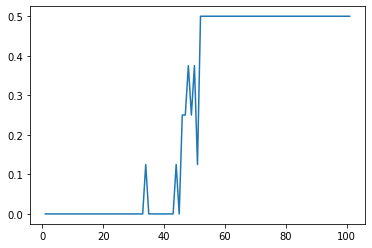

In [8]:
dfs[0]['min_rank'].plot()

In [13]:
import scipy.stats
# from sklearn.metrics import f1_score
#clf = SVC(C=1e5)
#clf.fit(X, y)

# print(f1_score(y, clf.predict(X)))

h = .01
x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

plt.figure(figsize=(10, 8))

# Put the result into a color plot
# p = noise level = avg number of points with flipped labels
# p = 0.1
# noise symmetric to both positive and negative region?
# negative point -> scale with largest negative distance (similar to positive)
# Random noise ~ 2%, 4%, 8%, 16%, 
# Sampling 100 
sigma = 3.0
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = 2 * (1 - scipy.stats.norm.cdf(np.abs(Z.reshape(xx.shape)) / sigma))
plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.8)
plt.colorbar()

# Plot also the training points
#plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
plt.xlim(-0.2, 0.2)
plt.ylim(-0.2, 0.2)
plt.show()

NameError: name 'clf' is not defined

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

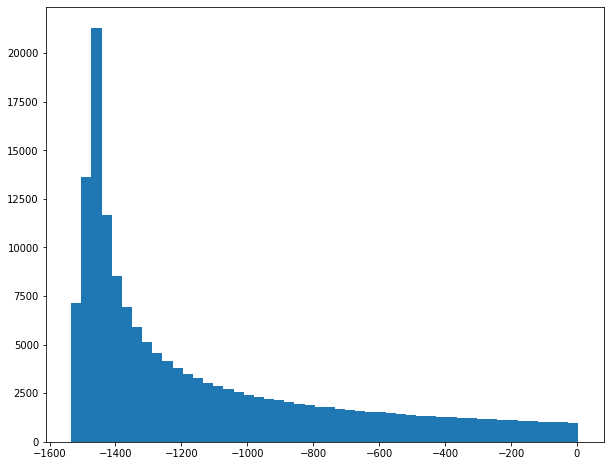

In [82]:
h = .01
x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

plt.figure(figsize=(10, 8))

# Put the result into a color plot
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])

plt.figure(figsize=(10, 8))
plt.hist(Z.ravel(), bins=50)
plt.show()

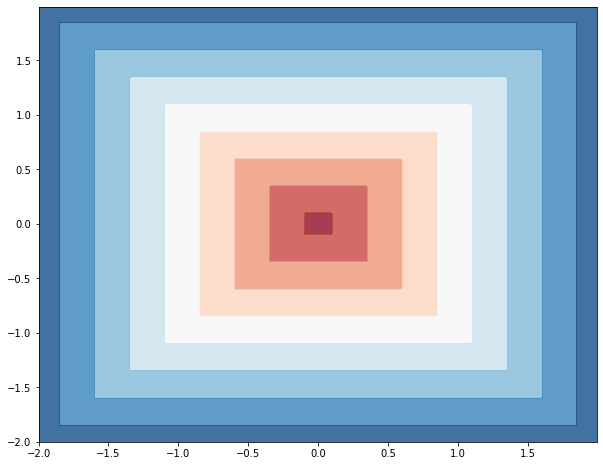

In [47]:
h = .01
x_min, x_max = -2, 2
y_min, y_max = -2, 2
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

plt.figure(figsize=(10, 8))

# Put the result into a color plot
#Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = np.empty(xx.shape)
a, b = -0.1, 0.1
c, d = -0.1, 0.1
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        Z[i, j] = max(a - xx[i, j], xx[i, j] - b, c - yy[i, j], yy[i, j] - d)
#         if -0.1 < xx[i, j] < 0.1 and -0.1 < yy[i, j] < 0.1:
#             Z[i, j] = 1
#         else:
#             Z[i, j] = -1

Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.8)

# Plot also the training points
#plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()